## Note:
this is a workbook notebook for testing the baseline, lstm and cnn model... the final notebook will have much more examples and will have visualization on how the data looks

In [22]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import lstm_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])


In [3]:
full_df.shape

(52696, 5)

In [4]:
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print df.shape
df.head(10)

(5270, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,103269,83547,2125-05-05 00:00:00,3942 2851 4019 4280 2767 25000 32723 30000 530...,Admission Date: [**2125-4-30**] ...
1,153808,82416,2119-07-17 00:00:00,41401 99702 412 07054 42731 78194 311 53085 30393,Admission Date: [**2119-7-11**] ...
2,170409,5806,2161-01-30 00:00:00,85200 3484 5185 48241 85220 311 4019 30000,Admission Date: [**2161-1-25**] ...
3,112476,28173,2182-04-05 00:00:00,5070 03840 99592 51881 70703 41051 5990 78552 ...,Admission Date: [**2182-3-9**] D...
4,187156,71225,2102-07-22 00:00:00,1510 5180 5119 3383 25002 78791 9984,Admission Date: [**2102-7-11**] ...
5,177724,13401,2188-03-27 00:00:00,0389 51881 78552 5070 70714 6827 73007 6826 71...,Admission Date: [**2188-3-21**] ...
6,130910,11318,2120-07-03 00:00:00,5168 4280 51881 7907 99662 42731 4590 25000 5939,"Name: [**Known lastname 17151**], [**Known fi..."
7,167835,40923,2142-07-13 00:00:00,5789 042 5723 53550 53789 5715 07054 49390 250...,Admission Date: [**2142-7-12**] ...
8,164360,88976,2154-07-30 00:00:00,4240 4295 2762 42731 53081 4019 42789 2724 311,Admission Date: [**2154-7-26**] ...
9,137250,969,2162-05-11 00:00:00,42823 7994 4280 4148 4168 4242 42731 5859 7070...,Admission Date: [**2162-5-3**] D...


## Pre processing ICD 9 codes

In [5]:
# instead of finding out the top 20 leave icd-9 codes and filter records based on that
# we will use all records and replace the leave icd-9 codes with its grandparents code in the first level of the hierarchy
#N_TOP = 20 
#full_df, top_codes = database_selection.filter_top_codes(df, 'ICD9', N_TOP, filter_empty = True)
#df = full_df.head(1000)

### Replacing leave icd-9 codes with their grandparent icd-9 code in the first level of the hierarchy

Source: https://github.com/sirrice/icd9   
The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).  

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.
```
001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-789 SYMPTOMS 
790-796 NONSPECIFIC ABNORMAL FINDINGS 
797 Senility without mention of psychosis
798 Sudden death, cause unknown
799 Other ill-defined and unknown causes of morbidity and mortality
800-999 INJURY AND POISONING 
```

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level,
for example:
```
leave-code  code-at-first-level
64833    -> 630-679
4019     -> 390-459
```

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [6]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,103269,83547,2125-05-05 00:00:00,240-279 390-459 290-319 520-579 320-389,Admission Date: [**2125-4-30**] ...
1,153808,82416,2119-07-17 00:00:00,001-139 390-459 290-319 520-579 800-999 780-789,Admission Date: [**2119-7-11**] ...
2,170409,5806,2161-01-30 00:00:00,390-459 320-389 290-319 460-519 800-999,Admission Date: [**2161-1-25**] ...
3,112476,28173,2182-04-05 00:00:00,240-279 001-139 290-319 390-459 680-709 460-51...,Admission Date: [**2182-3-9**] D...
4,187156,71225,2102-07-22 00:00:00,240-279 460-519 800-999 780-789 140-239 320-389,Admission Date: [**2102-7-11**] ...
5,177724,13401,2188-03-27 00:00:00,240-279 001-139 290-319 680-709 460-519 800-99...,Admission Date: [**2188-3-21**] ...
6,130910,11318,2120-07-03 00:00:00,240-279 390-459 460-519 800-999 580-629 790-796,"Name: [**Known lastname 17151**], [**Known fi..."
7,167835,40923,2142-07-13 00:00:00,001-139 240-279 390-459 460-519 520-579,Admission Date: [**2142-7-12**] ...
8,164360,88976,2154-07-30 00:00:00,240-279 390-459 290-319 520-579,Admission Date: [**2154-7-26**] ...
9,137250,969,2162-05-11 00:00:00,680-709 390-459 290-319 799 780-789 580-629,Admission Date: [**2162-5-3**] D...


In [7]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print icd9_codes
print 'Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level

Counter({'390-459': 4149, '240-279': 3476, '290-319': 2809, '460-519': 2481, '800-999': 2206, '580-629': 2138, '520-579': 2036, '780-789': 1699, '320-389': 1537, '001-139': 1443, '710-739': 962, '140-239': 890, '680-709': 591, '760-779': 522, '790-796': 454, '799': 151, '630-679': 10})
Number of icd9 codes in the first level that have notes in the dataset: 17


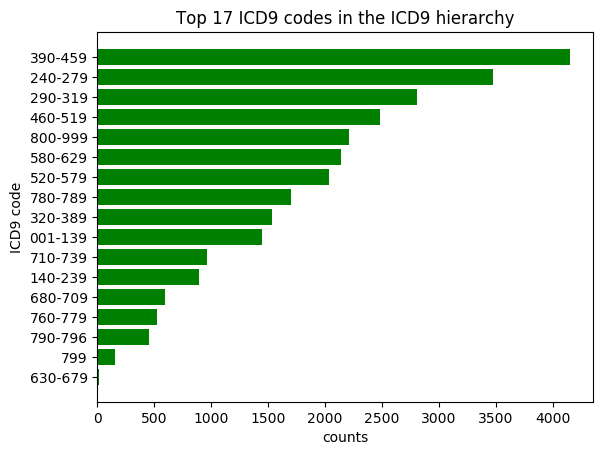

In [8]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [9]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)
print 'sample of vectorized icd9 labels: ', labels[0]


sample of vectorized icd9 labels:  [0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


## Pre process Notes

In [10]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data, MAX_SEQ_LENGTH)
print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 45264
Average note length: 1639.76413662
Max note length: 8725
Final Vocabulary: 45264
Final Max Sequence Length: 5000


In [11]:
#creating embeddings
EMBEDDING_LOC = '../data/glove.6B.100d.txt' # location of embedding
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True)


('Vocabulary in notes:', 45264)
('Vocabulary in original embedding:', 400000)
('Vocabulary intersection:', 22001)


## Split Files

In [12]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 5000), (3688, 19))
('Validation: ', (1054, 5000), (1054, 19))
('Test: ', (528, 5000), (528, 19))


In [13]:
# Delete temporary variables to free some memory
del df, data, labels

## Super Basic Baseline with top 4
Always predict top 4

In [14]:
# finding out the top icd9 codes
top_4_icd9 = icd9_codes.most_common(4)
print "most common 4 icd9_codes: ", top_4_icd9
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print 'label for the top 4 icd9 codes: ', top_4_icd9_label

most common 4 icd9_codes:  [('390-459', 4149), ('240-279', 3476), ('290-319', 2809), ('460-519', 2481)]
label for the top 4 icd9 codes:  390-459 240-279 290-319 460-519


In [15]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorization.vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print ICD9_FIRST_LEVEL
print top4_icd9_vector

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)

In [17]:
helpers.show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)

F1 scores
threshold | training | dev  
0.020:      0.532      0.526
0.030:      0.532      0.526
0.040:      0.532      0.526
0.050:      0.532      0.526
0.055:      0.532      0.526
0.058:      0.532      0.526
0.060:      0.532      0.526
0.080:      0.532      0.526
0.100:      0.532      0.526
0.200:      0.532      0.526
0.300:      0.532      0.526
0.500:      0.532      0.526


## Basic LSTM 

In [23]:
reload(lstm_model)
#### build model
l_model = lstm_model.build_lstm_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 5000, 100)         4526500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 19)                1919      
Total params: 4,608,819
Trainable params: 4,608,819
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
l_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
426s - loss: 13.5396 - acc: 0.0995 - val_loss: 13.1716 - val_acc: 0.1082
Epoch 2/5
426s - loss: 13.2312 - acc: 0.1396 - val_loss: 13.1228 - val_acc: 0.1110
Epoch 3/5
427s - loss: 13.1387 - acc: 0.1220 - val_loss: 13.0765 - val_acc: 0.1641
Epoch 4/5
439s - loss: 13.1264 - acc: 0.1296 - val_loss: 13.0959 - val_acc: 0.1518
Epoch 5/5
441s - loss: 13.0848 - acc: 0.1472 - val_loss: 13.0453 - val_acc: 0.1167


In [25]:
pred_train = l_model.predict(X_train, batch_size=50)
pred_dev = l_model.predict(X_val, batch_size=50)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.576      0.571
0.030:      0.607      0.602
0.040:      0.632      0.626
0.050:      0.643      0.637
0.055:      0.647      0.639
0.058:      0.647      0.635
0.060:      0.646      0.635
0.080:      0.604      0.589
0.100:      0.524      0.511
0.200:      0.075      0.069
0.300:      0.026      0.022
0.500:      0.026      0.021


## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [48]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.9,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 5000, 100)     4460200     input_3[0][0]                    
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 4999, 100)     20100       embedding_3[0][0]                
____________________________________________________________________________________________________
conv1d_10 (Conv1D)               (None, 4998, 100)     30100       embedding_3[0][0]                
___________________________________________________________________________________________

In [49]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
106s - loss: 39.0906 - acc: 0.0895 - val_loss: 13.7156 - val_acc: 0.2505
Epoch 2/5
105s - loss: 20.0010 - acc: 0.0927 - val_loss: 13.2616 - val_acc: 0.1698
Epoch 3/5
105s - loss: 15.3538 - acc: 0.1236 - val_loss: 13.1849 - val_acc: 0.1461
Epoch 4/5
105s - loss: 14.1284 - acc: 0.1451 - val_loss: 13.1301 - val_acc: 0.1546
Epoch 5/5
105s - loss: 13.6890 - acc: 0.1630 - val_loss: 13.0755 - val_acc: 0.1366


In [50]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)

In [52]:
# perform evaluation
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.529      0.530
0.030:      0.567      0.566
0.040:      0.598      0.595
0.050:      0.620      0.612
0.055:      0.628      0.617
0.058:      0.631      0.618
0.060:      0.633      0.620
0.080:      0.616      0.589
0.100:      0.481      0.465
0.200:      0.024      0.023
0.300:      0.017      0.018
0.500:      0.005      0.004


### TO DO: model for Thresholding
Papers about Thresholding:    

* "Convolutional Neural Network using a Threshold Predictor for Multi-label Speech Act Classification"   
* "A Study on Threshold Selection for Multi-label Classification"   

These papers mention they use a model for thresholding, but it is not the main topic:   
* "A Review on Multi-Label Learning Algorithms"   
* "Large-scale Multi-label Text Classification—Revisiting Neural Networks"*   
* "A multi-label convolutional neural network for automatic image annotation"

### Results with external embeddings = True , no additional training,  top 20
```
F1 scores
threshold | training | dev  
0.020:      0.337      0.329
0.030:      0.360      0.353
0.040:      0.365      0.374
0.050:      0.372      0.375
0.055:      0.370      0.377
0.058:      0.369      0.375
0.060:      0.368      0.375
0.080:      0.348      0.361
0.100:      0.309      0.319
0.200:      0.198      0.208
0.300:      0.157      0.138
0.500:      0.000      0.000
```

### Results with external embeddings = False, top 20
```
F1 scores
threshold | training | dev  
0.020:      0.288      0.300
0.030:      0.327      0.322
0.040:      0.371      0.363
0.050:      0.380      0.391
0.055:      0.412      0.383
0.058:      0.403      0.394
0.060:      0.394      0.389
0.080:      0.385      0.390
0.100:      0.229      0.225
0.200:      0.000      0.000
0.300:      0.000      0.000
0.500:      0.000      0.000
```

### Results with external embedding and training them , top 20
```
F1 scores
threshold | training | dev  
0.020:      0.334      0.333
0.030:      0.362      0.360
0.040:      0.366      0.374
0.050:      0.373      0.380
0.055:      0.374      0.382
0.058:      0.376      0.376
0.060:      0.376      0.378
0.080:      0.387      0.371
0.100:      0.366      0.350
0.200:      0.179      0.171
0.300:      0.020      0.020
0.500:      0.000      0.000

```

### Results with external Embeddings = False, top 10, 
We can compare this setup with the LSTM published in the paper "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records", they got a F1-score of about 0.4168, we are getting 0.447

``` 
F1 scores
threshold | training | dev  
0.020:      0.399      0.407
0.030:      0.399      0.407
0.040:      0.399      0.407
0.050:      0.408      0.413
0.055:      0.433      0.420
0.058:      0.437      0.430
0.060:      0.432      0.427
0.080:      0.501      0.463
0.100:      0.446      0.463
0.200:      0.206      0.066
0.300:      0.000      0.000
0.500:      0.000      0.000
```



## Notes:


(1) There is a LSTM model by this paper: "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records" which did achieve a 42% F1-score. (https://cs224d.stanford.edu/reports/priyanka.pdf), but it only uses the top 10 icd9 codes. We are getting 46% (just running with 1000 notes so far)


(2) The "A Comparison of Rule-Based and Deep Learning Models for Patient Phenotyping"  study did get a 70% F1-score, but they don't use the icd9-labels but phenotypes labels they annotated themselved (via a group of medical professionals). (https://arxiv.org/abs/1703.08705). There were ONLY 10 phenotypes.

The discharge summaries are labeled with ICD9-codes that are leaves in the ICD9-hierarchy (which has hundreds of ICD9-codes), then maybe these leave nodes are too specific and difficult to predict, one experiment would be to replaced all the ICD9-codes with their parent in the second or third level in the hierarchy and see if predictions work better that way.   

(3) our baseline with top 20 codes had a f1-score of 35% (assigning top 4 icd9 codes to all notes, using a CNN with no external embeddings is getting about 40% f1-score.. a little better than the baseline

(4) Papers published and best practices report  that external embeddings improve considerable the model's performance.. maybe it is not the case here because of the medical terms..   

(5) Fixed Thresholding doesn't work well for multilabel classifications, we can implement a model to choose the appropriate threshold for each record (see notes above)

(6) for loss function: binary and categorical cross entropy gave same results